In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import statistics
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import random
import hyperloglog
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import collections
from collections import defaultdict
from collections import Counter
import pickle
import ast
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import seaborn as sns
from matplotlib import cm
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
import multiprocessing.dummy as mp 
import json

## 1. HASHING

- https://en.wikipedia.org/wiki/Fowler%E2%80%93Noll%E2%80%93Vo_hash_function#FNV-1_hash
- https://github.com/sup/pyhash/blob/master/pyhash/pyhash.py
- https://www.geeksforgeeks.org/what-are-hash-functions-and-how-to-choose-a-good-hash-function/
- http://www.euroinformatica.ro/documentation/programming/!!!Algorithms_CORMEN!!!/DDU0066.html
- https://github.com/svpcom/hyperloglog

In [2]:
# not needed
def importing_requests(file):
    f=open(file,'r')
    requests = f.read().split('\n')
    return requests

https://medium.com/@raghavan99o/hyperloglog-algorithm-part-i-flajolet-martin-algorithm-b4dcc9be3031

In [3]:
def convert(string):
    s=0
    for char in string:
        s+=ord(char)
    return int(s)

In [4]:
def my_hash(string):
    n = 106033 # must be greater than expected size
    IP = string
    r = int(len(IP)/2)
    q = [IP[:r//2],IP[r//2:r],IP[r:r+r//2],IP[r+r//2:]]
    a=[2,17,4,32]
    h=0

    for i in range(4):
        x = int(convert(q[i]))
        h += (x*a[i])%n
    return str(bin(h).split('b')[1])

In [5]:
# 125000001 real len of set

def HLL_real(file,nlines):
    f = open(file, "r")
    hll = hyperloglog.HyperLogLog(0.01)  # accept 1% counting error
    for n in range(1,nlines):
        req = f.readline(n)
        hll.add(h)
    
    return len(hll) 

https://pangaj.github.io/HyperLogLog/

In [6]:
def tail_zeros(b):
    i = 1
    while b[-i] == '0' and i<len(b):
        i+=1
    return i

In [7]:
def HLL(file,nlines):
    f = open(file, "r")
    B = []
    buckets = [0]*4
    for n in range(1,nlines): # 139000000, 100001
        req = f.readline(n)
        b = my_hash(req)
        B.append(b[1:])
        index = int(b[1])*2 + int(b[2]) 
        zeros = tail_zeros(b[2:])
        buckets[index]=max(buckets[index],zeros) 
    cardinality = 2**np.mean(buckets)
    #loglog = np.log(np.log(cardinality))
    error = (1.3/math.sqrt(4))*(n/100)
    return cardinality, buckets, error, B

In [ ]:
c,b,e,B = HLL('small.txt',100001)

In [ ]:
print(HLL_real('small.txt',100001))

# 2. CLUSTERING

## Importing dataset

In [ ]:
dataset = pd.read_csv('Reviews.csv',nrows=1000)
dataset['ProfileName'].fillna('',inplace=True)
dataset['Summary'].fillna('',inplace=True)
dataset.set_index('Id',inplace=True)

## Analysis of the dataset

In [2]:
#an example of a text that we will have to analyze

data = pd.read_csv('Reviews.csv', usecols = ['ProductId','Summary','Text'])
data.Text[6745]

"I love juice and I love carbonated beverages, but it is difficult to see this product having a long retail life.<br /><br />Essentially, this is a good drink that doesn't really do anything well.<br /><br />It doesn't taste good enough to be a juice replacement--and is there really a need for a juice replacement?  It might have limited value in camping situations or during other times where small cans make better travelers.<br /><br />It's not exactly a post-workout recovery drink.  Juice would be better.  Minute Maid juice, for instance, has less sugar and carbohydrates, even though Switch doesn't add any sugar.  And there are plenty of other juices that have more nutrients, including Calcium and other vitamins and supplements, including potassium.  So, it's less healthy than most juices.<br /><br />Switch isn't exactly a diet soda because of the natural sugar content comapared to zero sugar in diet drinks.<br /><br />As a regular alternative to sugared soda, it tastes good, but ther

In [4]:
print(f'number of unique products: {len(data.ProductId.unique())} \nnumber of total rows in the dataset: {data.shape[0]}')

number of unique products: 74258 
number of total rows in the dataset: 568454


In [5]:
data.groupby('ProductId').count()

Summary  Text
ProductId                
0006641040       37    37
141278509X        1     1
2734888454        2     2
2841233731        1     1
7310172001      173   173
...             ...   ...
B009UOFTUI        1     1
B009UOFU20        1     1
B009UUS05I        1     1
B009WSNWC4        1     1
B009WVB40S        1     1

[74258 rows x 2 columns]

In [6]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Summary    568427 non-null  object
 2   Text       568454 non-null  object
dtypes: object(3)
memory usage: 13.0+ MB


useful: https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d 

also: https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b

Importing preprocessed files

In [2]:
#Useful functions to save and load files in pickle format

def save_dict(obj, name ):
    with open(f'{name}.pickle', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(f'{name}.pickle', 'rb') as f:
        return pickle.load(f)
    
# run

## Preprocessing

This pre-processing stage refers to the series of treatments that must be done to the corpus so that it can be well represented by statistic model before it’s fed to the K-Means algorithm. The pre-processing routine is divided as such:
- **Corpus tokenization**, that is, divide the different texts into individual words.
- **Stop words removal**, which are common words (a, the, not, etc) that bring close to no contribution to the semantic meaning of a text
- **Noise removal** from the texts, that means basically anything that can’t be recongnized as a english word, such as words with non ASCII symbols, words together with numbers, etc.
- **Stemming**, which reduces a word to it’s root. 


In [8]:
def pre_processing_data(text):           
    
    stop_words = set(stopwords.words('english'))
    text = (text.lower()).replace('\\n',' ')        #converts to lower case and removes extra space
    
    text = text.replace("\r","")
    text = text.replace("\n","")
    text = text.replace("<br />","")
    
    text = text.encode("ascii", "ignore")            #removes non ASCII characters
    text = text.decode()
    
    punctuation = RegexpTokenizer(r'\w+')               #identifies punctuation
    tokens = punctuation.tokenize(text)               #create a list of all words

    ps = PorterStemmer()

    filtered_text = []
    for word in tokens:
        if word not in stop_words:
            filtered_text.append(ps.stem(word))
    
    return filtered_text

All the cells below were runned only the FIRST time and then saved into a csv file for easier access

`wordlist = data['Text'].apply(lambda text: pre_processing_data(text))` \
`data['text_words'] = wordlist` \
`data.to_csv('clean_dataset.csv')`

## Create a vocabulary with all the unique words from text_words

In [9]:
#to import directly the filtered dataset instead of pre-process everything again
data = pd.read_csv('clean_dataset.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

#to mantain the format of text_words as a list and not as a string
data['text_words'] = data['text_words'].map(ast.literal_eval)

In [10]:
def build_dictionary(df):                            

    vocabulary_list = []
    vocabs_in_reviews = defaultdict(list)

    for i in range(len(df)):

        text_filtered = df['text_words'][i]
        
        vocabs_review_i=set()
        for word in text_filtered:
            vocabs_review_i.add(word)

        vocabulary_list.append(vocabs_review_i)
        vocabs_in_reviews[i]=list(vocabs_review_i)

    bag_of_words = set.union(*vocabulary_list)
    
    dictionary = {}
    for num, word in enumerate(bag_of_words):
        dictionary[word] = num
    
    return dictionary

`dictionary = build_dictionary(data)`   -    to build \
`save_dict(dictionary,'dictionary')` - to save

In [10]:
dictionary = load_obj('dictionary')   #to load it back
len(dictionary)

109234

## Frequencies
For every unique product ID combine the list of words from different reviews together.

In [11]:
products = list([data.ProductId[i] for i in range(len(data))])
unique_products = list(dict.fromkeys(products))

In [13]:
print(len(products))
print(len(unique_products))

568454
74258


In [ ]:
new_data = dict.fromkeys(unique_products)

for product in unique_products:
    index = (np.where(data['ProductId']==product))[0].tolist()

    reviews = []
    for i in index:
        text = data['text_words'][i]
        reviews += text
    
    new_data[product] = reviews

`save_dict(new_data,'new_data')` - to save

In [12]:
reviews_per_product = load_obj('new_data') #to load

In [15]:
len(reviews_per_product)

74258

In [13]:
frequency_of_word = []
for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)
frequency_of_word

[Counter({'bought': 1,
          'sever': 1,
          'vital': 1,
          'can': 1,
          'dog': 1,
          'food': 1,
          'product': 3,
          'found': 1,
          'good': 1,
          'qualiti': 1,
          'look': 1,
          'like': 1,
          'stew': 1,
          'process': 1,
          'meat': 1,
          'smell': 1,
          'better': 2,
          'labrador': 1,
          'finicki': 1,
          'appreci': 1}),
 Counter({'product': 2,
          'arriv': 1,
          'label': 1,
          'jumbo': 2,
          'salt': 1,
          'peanut': 2,
          'actual': 1,
          'small': 1,
          'size': 1,
          'unsalt': 1,
          'sure': 1,
          'error': 1,
          'vendor': 1,
          'intend': 1,
          'repres': 1}),
 Counter({'confect': 1,
          'around': 1,
          'centuri': 1,
          'light': 1,
          'pillowi': 1,
          'citru': 1,
          'gelatin': 1,
          'nut': 1,
          'case': 1,
          'f

In [17]:
len(frequency_of_word)

74258

In [18]:
def frequency(vocabulary,frequency_of_word):
    f = defaultdict()
    for word in vocabulary.keys():
        f[word] = sum(frequency_of_word[i][word] for i in range(len(frequency_of_word)) if word in frequency_of_word[i])
    return f   

`freq = frequency(dictionary,frequency_of_word)` - to build \
`save_dict(freq,'frequencies')` - to save

In [23]:
frequencies = load_obj('frequencies') #to load

In [20]:
print('max: ',max(list(frequencies.values())))
print('min: ',min(list(frequencies.values())))

max:  288508
min:  1


## Filtering by frequencies

In [17]:
def filter_words(frequencies):
    
    useful_words = []                                 #list that contains all the words that we think are useful for clustering
    frequent_words = []                               #list that contains all the words over a certain treshold 

    for key, value in frequencies.items():
        if value > 20 and value < 200000:             #we decided to only consider the words that are inside this range of frewuencies 
            useful_words.append(key)
        elif value > 200000:
            frequent_words.append(key)
    
    return(useful_words, frequent_words)
        
useful_words = filter_words(frequencies)[0]
frequent_words = filter_words(frequencies)[1]

By doing this we will reduce the length of the dictionary that will contain all the different unique words found inside the reviews. we noticed that words with very low frequencies are pretty rare or they could be wrong words, with spelling mistakes, hence, with no meaning.
The length will go from `len(dictionary) = 109234 ` to `len(useful_words) = 14783 `

In [10]:
frequent_words

['product', 'good', 'tast', 'flavor', 'like']

As we can see above, all the words with very high frequencies are very common words, so they will not be useful in the determination of the cluster in which a certain review will belong

In [18]:
def new_dictionary(useful_words):
    
    dictionary = defaultdict()
    
    for i, word in enumerate(useful_words):
        dictionary[word] = i
    
    return dictionary

dictionary_filtered = new_dictionary(useful_words)

## Occurrence matrix
Now we want to create a matrix that will have the following structure:
- each column will represent one word from the list **useful_words**
- each row represents a different unique product id

Each **cell** of the matrix will represent the frequence of that certain word inside the reviews of that certain product

In [27]:
matrix = np.zeros((len(unique_products),len(dictionary_filtered)))
for i, product in enumerate(unique_products):      #per ogni prodotto con indice i   
    for word,j in dictionary_filtered.items():          #per ogni parola con indice j nel dizionario
        if word in frequency_of_word[i].keys():        #se la parola si trova nel dizionario di frequenze del prodotto
            matrix[i][j] += frequency_of_word[i][word]

In [28]:
matrix.shape

(74258, 14783)

In [29]:
a = np.zeros((len(unique_products),len(dictionary_filtered)))

## Singular value decomposition

In [73]:
svd = TruncatedSVD(n_components = 70,n_iter=3, random_state=42)
svd.fit(matrix)

TruncatedSVD(n_components=70, n_iter=3, random_state=42)

In [74]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 88%


Each dimension is a linear combination of input features. To understand what a particular dimension mean take a look at svd.components_ array - it contains a matrix of coefficients input features are multiplied by.

In [75]:
components = svd.components_
features = useful_words

In [76]:
print(components.shape)
components[0]

(70, 14783)


array([2.61458657e-04, 2.08688090e-05, 1.67157890e-02, ...,
       1.14701734e-05, 6.34622146e-04, 4.84766436e-05])

In [77]:
components_features = {i: [] for i in range(len(components))} 
n_comp = len(components)
for i in range(n_comp):
    ith_comp = components[i]
    for coef,feat in zip(ith_comp,features):
        if  coef > 10**(-2):
            components_features[i].append(feat)

In [78]:
relevant_words = list(set(list(components_features.values())[0]))
print(len(relevant_words))
print(relevant_words)

458
{'add', 'week', 'packet', 'quickli', '1', 'other', 'review', 'coupl', 'health', 'put', 'qualiti', 'mayb', 'wife', 'dri', 'blend', 'natur', 'salt', 'favorit', 'piec', 'result', 'organ', 'go', 'someth', 'much', 'maker', 'offer', 'easi', 'expect', 'husband', 'sweeten', 'may', 'cold', 'bowl', 'ok', 'note', 'thought', 'run', 'cereal', 'must', 'similar', 'left', 'kid', 'less', 'better', 'addit', 'perfect', 'start', 'brand', 'probabl', 'made', 'work', 'pet', 'weak', 'open', 'brewer', 'dog', 'juic', 'seem', 'name', 'honey', 'guess', 'next', 'test', 'fat', 'second', 'great', 'slightli', 'would', 'varieti', 'sauc', 'cook', 'use', 'full', 'includ', 'pour', 'tell', 'pay', 'home', 'com', 'anyon', 'artifici', 'well', 'black', 'bit', 'issu', 'conveni', 'notic', 'gener', 'long', 'marley', 'fruit', 'sweet', 'excel', 'turn', 'anyth', 'vitamin', 'amount', 'feel', 'goe', 'bake', 'disappoint', 'end', 'thing', 'ice', 'grain', 'pack', '8', 'local', 'low', 'leav', 'hope', 'best', 'teeth', 'three', 'chew',

In [ ]:
#to update reviews_per_product
for key, value in reviews_per_product.items():
    reviews_per_product[key] = [word for word in value if word in relevant_words]
frequency_of_word = []

for key, item in reviews_per_product.items():
    frequency_of_words = Counter(item)
    frequency_of_word.append(frequency_of_words)
frequency_of_word

In [ ]:
final_dictionary = new_dictionary(relevant_words) 

## Calculate Tf-Idf Scores for each word inside the reviews of a product ID

In [ ]:
def tf(frequency_of_word,review_per_products):      
 
    tfs = []

    for i, item in enumerate(reviews_per_product.items()):
        text_filtered = reviews_per_product[item[0]]

        tf = dict.fromkeys(text_filtered,0)
        tot_number_of_words = len(text_filtered)

        for key,item in frequency_of_word[i].items():
            frequency = item
            tf_score = frequency / tot_number_of_words
            tf[key] = tf_score    
        tfs.append(tf)
        
    return tfs

In [ ]:
def idf(dictionary,frequency_of_word,reviews_per_product):    
    
    N = len(reviews_per_product)
    idf = dict.fromkeys(dictionary.keys(), 0)

    #calculate df by looking at the number of documents each token appears
    for i in range(len(reviews_per_product)):
        for key,item in frequency_of_word[i].items():
            if item > 0:
                idf[key] += 1
                
    #calculate idf 
    for key,item in idf.items():
        idf[key] = np.log(N/(item))
        
    return idf

In [ ]:
def tf_idf_score(tf_score,idf_score,reviews_per_product):    

    tf_idf_scores = []
    for i in range(len(reviews_per_product)):
        tf_idf_score = {}
        for key,item in tf_score[i].items():
            tf_idf_score[key] = round(item*idf_score[key],5) 
        tf_idf_scores.append(tf_idf_score)

    return tf_idf_scores

In [ ]:
tf_score = tf(frequency_of_word,reviews_per_product)
idf_score = idf(dictionary,frequency_of_word,reviews_per_product)
tf_idf_scores = tf_idf_score(tf_score,idf_score,reviews_per_product)

In [93]:
save_dict(tf_idf_scores,'tf_idf_scores')    #to save
final_dictionary = load_obj('tf_idf_scores')   #to load

## Distance matrix

In [3]:
''' Run '''
final_dictionary = load_obj('tf_idf_scores') 
# prods = range(len(final_dictionary))
prods = range(len(final_dictionary))[10000:] # questo gira tutto dalla riga 10000 in poi
n = len(prods)
matrix = {i: [] for i in range(n)} 
all_words = sorted(['add', 'week', 'packet', 'quickli', '1', 'other', 'review', 'coupl', 'health', 'put', 'qualiti', 'mayb', 'wife', 'dri', 'blend', 'natur', 'salt', 'favorit', 'piec', 'result', 'organ', 'go', 'someth', 'much', 'maker', 'offer', 'easi', 'expect', 'husband', 'sweeten', 'may', 'cold', 'bowl', 'ok', 'note', 'thought', 'run', 'cereal', 'must', 'similar', 'left', 'kid', 'less', 'better', 'addit', 'perfect', 'start', 'brand', 'probabl', 'made', 'work', 'pet', 'weak', 'open', 'brewer', 'dog', 'juic', 'seem', 'name', 'honey', 'guess', 'next', 'test', 'fat', 'second', 'great', 'slightli', 'would', 'varieti', 'sauc', 'cook', 'use', 'full', 'includ', 'pour', 'tell', 'pay', 'home', 'com', 'anyon', 'artifici', 'well', 'black', 'bit', 'issu', 'conveni', 'notic', 'gener', 'long', 'marley', 'fruit', 'sweet', 'excel', 'turn', 'anyth', 'vitamin', 'amount', 'feel', 'goe', 'bake', 'disappoint', 'end', 'thing', 'ice', 'grain', 'pack', '8', 'local', 'low', 'leav', 'hope', 'best', 'teeth', 'three', 'chew', 'give', 'extra', 'protein', 'although', 'chip', 'meat', 'back', 'strong', 'individu', 'person', '100', 'year', 'brew', 'senseo', 'hous', 'toy', 'big', 'four', 'fast', 'often', 'coffe', 'delici', 'base', 'nutrit', 'also', 'love', 'famili', 'plastic', 'total', 'enough', 'still', 'groceri', 'almost', 'mouth', 'quick', 'pod', 'compani', 'pouch', 'deal', 'filter', 'either', 'mani', 'regular', 'star', '12', 'usual', 'els', 'mountain', 'store', 'complet', 'energi', 'definit', 'squeez', 'formula', 'color', 'spice', 'order', 'minut', 'hard', 'right', 'peopl', 'though', 'hair', 'bean', 'compar', 'sinc', 'fill', 'time', 'decid', 'crunchi', 'said', 'sometim', 'espresso', 'cheaper', 'finish', 'side', 'live', 'keurig', 'k', 'cooki', 'see', 'larg', 'water', 'money', 'serv', 'rich', '6', 'meal', 'worth', 'rather', 'free', 'aftertast', 'plu', 'cream', 'rice', 'figur', 'believ', 'per', 'came', 'pot', 'price', 'want', 'corn', 'packag', 'reason', 'case', 'roast', 'cut', 'size', 'longer', 'bite', 'yet', 'could', 'amazon', 'tri', 'everyon', 'rate', 'find', 'actual', 'benefit', 'help', 'http', 'never', 'first', 'nut', 'sure', 'altern', 'care', 'fact', 'babi', 'healthi', 'nice', 'stop', 'avail', 'morn', 'greeni', 'gp', 'diet', 'starbuck', 'treat', 'box', 'ever', 'went', 'type', 'smooth', 'got', 'day', 'need', 'absolut', 'happi', 'least', 'thank', 'even', 'train', 'us', 'small', 'popcorn', 'bar', 'pretti', 'stomach', 'take', 'choic', 'set', 'real', 'decaf', 'top', 'effect', 'cat', 'normal', 'pick', 'medium', 'buy', 'vanilla', 'bought', 'new', 'hint', 'consid', 'pop', 'wonder', 'know', 'sugar', 'textur', 'away', 'oz', 'ad', 'experi', 'save', 'half', 'french', 'cup', 'month', 'hour', 'coconut', 'receiv', '10', 'chicken', 'amaz', 'satisfi', 'fresh', 'item', 'might', 'contain', 'recommend', 'light', 'whole', 'count', 'ounc', 'found', 'problem', 'two', 'hot', 'littl', 'stick', 'come', 'easili', 'can', 'food', 'way', 'bad', 'dark', 'let', 'think', 'origin', 'purchas', 'fan', 'kind', 'peanut', '5', 'around', 'bodi', 'gave', 'powder', 'look', 'alway', 'highli', 'noth', 'cours', 'part', 'market', 'switch', 'href', 'surpris', 'pleas', 'snack', 'singl', 'far', 'tea', 'everi', 'night', 'mild', 'mean', 'bottl', 'machin', 'last', 'vet', 'friend', 'butter', 'keep', 'skin', 'quit', 'bold', 'list', 'caffein', 'almond', 'tasti', 'abl', 'read', 'chang', 'carri', 'aroma', 'lot', 'milk', 'place', 'bitter', 'especi', 'without', 'soft', '50', 'cost', 'realli', 'old', 'bottom', 'instant', 'anoth', 'say', 'chocol', 'close', 'gluten', 'overal', 'call', 'calori', '4', 'everyth', 'fine', 'line', 'green', 'breakfast', 'etc', 'one', 'sever', 'wast', '3', 'instead', 'enjoy', 'acid', 'daili', 'howev', 'soda', 'ginger', 'drink', 'mix', 'get', 'wish', 'arriv', 'feed', 'continu', 'prefer', 'hand', 'valu', '2', 'took', 'point', 'stuff', 'oil', 'pill', 'high', 'drinker', 'ingredi', 'potato', 'www', 'expens', 'weight', 'idea', 'seal', 'ago', 'ship', 'clean', 'bag', 'eat', 'smell', 'make', 'ground', 'differ'])

In [4]:
''' Run '''
def calculate_distance(j):
    prod1 = final_dictionary[i] # we extract the tf-idf vector for product i
    prod2 = final_dictionary[j] # we extract the tf-idf vector for product j
    scores1 = []                # in this lists we will save the scores for calculating the cosine distance
    scores2 = []
    for word in all_words:      # we iterate the sorted list of words (we need to ensure that the indexes are the same)
        try:                      
            scores1.append(prod1[word]) # if that word is in the product we add the score
        except:
            scores1.append(1)           # else we add 1 (max distance)
        try:
            scores2.append(prod2[word])
        except:
            scores2.append(1)
    matrix[i].append(spatial.distance.cosine(scores1,scores2)) # we compute the cosine distance between the two lists (1 - cosine similarity)

    return matrix   

In [ ]:
''' Run '''
start = time.time()
for i in prods:                           # for each product index
    print (i,time.time()-start)          
    p = mp.Pool()                         # function for multiprocessing
    p.map(calculate_distance,prods[i:])   # map calculate distance between product i and all products with ids from id = i until 74258
    
    # stores one line for each dictionary key 
    
    with open('distance.txt', 'a') as outfile:
        json.dump(matrix[i], outfile)
        outfile.write('\n')

0 0.00010323524475097656
1 20.855303287506104
2 41.275967597961426
3 61.6682186126709
4 82.47438025474548
5 103.35289597511292
6 123.88995862007141
7 144.24974942207336
8 164.3020670413971
9 184.44000482559204
10 204.32249307632446
11 224.84322261810303
12 244.85666131973267
13 265.0571942329407
14 284.52284479141235
15 304.6599383354187
16 325.09158205986023
17 345.52292561531067
18 366.0714180469513
19 386.3433418273926
20 407.24290800094604
21 427.5796284675598
22 447.8432152271271
23 468.20078587532043
24 488.46318674087524
25 508.93479776382446
26 529.0743160247803
27 549.1189284324646
28 569.0917806625366
29 588.9029483795166
30 608.8567106723785
31 629.4027059078217
32 650.1639180183411
33 670.5982038974762
34 690.9225616455078
35 710.385495185852
36 730.4993841648102
37 750.9472706317902
38 771.8295569419861
39 792.1475465297699
40 812.3238463401794
41 832.6523714065552
42 852.8815557956696
43 873.0921413898468
44 893.3393201828003
45 913.4996800422668
46 933.753082036972
47 95

In [6]:
matrix[0]

[0.0,
 0.012616332205537817,
 0.01672490518675207,
 0.011680348693153708,
 0.04729774153505306,
 0.011111321242904038,
 0.012429417357380568,
 0.03211460821573675,
 0.036321074314833224,
 0.10532582353327635,
 0.029068810017055413,
 0.03211460821573675,
 0.03526618116684066,
 0.21875922636673184,
 0.05877943170292188,
 0.04216907750706744,
 0.04902916750555408,
 0.0122709837243411,
 0.09145530977458083,
 0.16971866333545071,
 0.042671085468229286,
 0.01965865908218767,
 0.04698520899254177,
 0.02057551208289976,
 0.025414746518489184,
 0.12108934815711148,
 0.07213657713804078,
 0.3188394074187374,
 0.10923761554370448,
 0.016044248123525895,
 0.012160466084412902,
 0.017454182277763186,
 0.013185707263116853,
 0.038768003589062516,
 0.14841227698412496,
 0.01959055098832929,
 0.4710872163903236,
 0.39154144917838574,
 0.016862612395888266,
 0.053406761006422165,
 0.020275843350129774,
 0.06900932273579274,
 0.013387485950764444,
 0.042307657344392124,
 0.01342080750792396,
 0.01950636

## K-Means

Testing with random distance matrix

In [2]:
N = 100
b = np.random.uniform(0, 1, size=(N,N))
m = (b + b.T)/2

K-means algorithm that is inizialized with random points and a number of clusters k. It returns a dictionary where the keys are the cluster ids, the ids of the random centroids, the clusters id associated to each centroid and the within cluster squared score.

In [3]:
def kmeans(k, matrix, centroids):   
    
    # inizializing output
    n_clusters = dict(zip(centroids,range(k)))            # cluster number centroids
    clusters = {i: [] for i in range(k)}                  # empty dictionary for clusters
    WSS = {i: 0 for i in range(k)}                        # will be used to calculate within cluster sum of squares
    
    for point1 in range(len(matrix)):                     # for each point 
        dist = 1                                          # we assume max dist in a range 0-1
        
        # for each centroid (cluster)
        for center in centroids:                          
            cluster_points = clusters[n_clusters[center]] # we consider all points in that cluster
            centroid_dist = matrix[center][point1]        # we calulate distance from centroid
            cum_dist = 0
            for point2 in cluster_points:                 # for each point in the centroid cluster
                cum_dist += matrix[point1][point2]        # we sum all distances
            
            mean_dist = (cum_dist+centroid_dist)/(len(cluster_points)+1) # we get the mean distance 

            if mean_dist < dist:                          # we check if the mean distance between the point and the centroid cluster is smaller than the previous dist
                cluster_id = n_clusters[center]           # assignes (temporarely) the point to cluster is k
                dist = mean_dist                          # update distance from centroid
        
        # point1 is assigned to the best cluster 
        clusters[cluster_id].append(point1)               # update with best cluster
        WSS[cluster_id] += dist                           # updating the chosed cluster with the squared distance from centroid
    
    # calculate mean distance for each cluster (wss)
    WSS = np.mean([WSS[i]/len(clusters[i]) for i in range(k)]) 
    
    return clusters, centroids, n_clusters, WSS

### Evaluating optimal number of clusters: 
Links: 
- https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/
- elbow and sil: https://www.youtube.com/watch?v=AtxQ0rvdQIA
- sil: https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111
- https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb
- gap: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

#### Elbow method: 
- Compute clustering algorithm for different values of k.
- For each k, calculate the total within-cluster sum of square (wss).
- Plot the curve of wss according to the number of clusters k.
- The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.
WSS: measures the squared average distance of all the points within a cluster to the cluster centroid. To calculate WCSS, you first find the Euclidean distance between a given point and the centroid to which it is assigned. You then iterate this process for all points in the cluster, and then sum the values for the cluster and divide by the number of points. Finally, you calculate the average across all clusters. 

In [4]:
def elbow_method(matrix,threshold):
    
    # inizialization
    elbow = []
    ks = range(5,20)
    
    # trying different clusters
    for k in ks:                                              # for each number of clusters
        centroids = random.sample(range(1, len(matrix)), k)   # pick random points
        clusters, centers, n_clusters, WSS = kmeans(k,matrix,centroids)
        elbow.append(WSS)                                     # we append for each iteration the WSS score
    i = 1                                                     
    optimal = 0                                               # we want to best compromise btw low n of clusters and low WSS
    
    # applying threshold
    stop = ((max(elbow)-min(elbow))/100)*threshold+min(elbow)
    while elbow[i] > stop and i<len(elbow)-1:                 # we stop when have reached the threshold% of optimal number of clusters     
        i+=1
        optimal = elbow[i]
    
    return elbow, ks[i]

#### Silhouette method:
- We vary k from 1 to 10 clusters.
- For each k, calculate the average silhouette of observations
- Plot the curve of avg.sil according to the number of clusters k.
- The location of the maximum is considered as the appropriate number of clusters

In [5]:
def silhouette_method(matrix):
    
    #inizialization
    ks = range(5,20)
    # points = {i: {} for i in ks} 
    scores = {}
    
    # trying different clusters 
    for k in ks:                                                      # for each number of clusters
        centroids = random.sample(range(1, len(matrix)), k)           # pick random points
        clusters, centers, n_clusters, WSS = kmeans(k,matrix,centroids)# we apply k-means
        s_score = {}
        points = {}                                                   # add a dictionary where keys are the point and clusters id are the value
        
        # creating points dictionary
        for cluster in clusters.keys():                               # for each cluster in k-means
            points.update(dict(zip(clusters[cluster],[cluster]*len(clusters[cluster])))) 
        
        # calculating mean distance and silhouette score
        for point1 in points.keys():                                  # for each point
            point1_cluster = points[point1]                           # we extract its cluster
            in_distance = 0
            out_distance = 0
            points_in = clusters[point1_cluster]                      # points in same cluster
            points_out = set(points.keys()).difference(set(points_in))# any other point
            
            for point2 in points_in:                                  # for each point in the same cluster
                in_distance+=matrix[point1][point2]                   # we add distance btw point1 and point2 to in_distance
            for point2 in points_out:                                 # for each any other point 
                out_distance+=matrix[point1][point2]                  # we add distance btw point1 and point2 to out_distance
            
            avarage_in = in_distance/len(points_in)                   # we compute avarage distance for both
            avarage_out = out_distance/len(points_out)
            s = (avarage_out-avarage_in)/max(avarage_in,avarage_out)  # we calculate silhouette score
            s_score[point1]=s                                         # we store sil_score for each point
        
        scores[k]=s_score
    
    df=pd.DataFrame.from_dict(scores)
    
    return df, df.columns[df.sum().argmax()]

#### Trying different random initializations

In [6]:
def kmeans_optimize(k,matrix,iterations):
    
    # inizialization
    plot_data={}
    all_wss = []
    all_centers = []
    
    # simulations
    for i in range(iterations):                               # for each simulation
        centroids = random.sample(range(1, len(matrix)), k)   # pick random points
        itr = []
        clusters, centers, n_clusters, WSS = kmeans(k,matrix,centroids) # a different set of random centroids is generated
        for n in n_clusters.values():                         # for each cluster 
            itr.append(len(clusters[n])/len(m))               # we save the percentage of point it contains
        plot_data['iter_'+str(i)]=itr                         # save data to plot for each iteration
        all_wss.append(WSS)                                   # save WSS for each iteration
        all_centers.append(centers)                           # save centroids
    
    # defining best result
    best = all_wss.index(min(all_wss))                       # the best result is that with lowest wss score
    
    return plot_data,all_centers,all_wss,best

#### Optimized k-means
We combine all the results obtained with the functions above

In [7]:
def optimize(matrix,iterations):
    
    # optimal number of clusters methods:
    # 1. elbow method
    scores_e, e = elbow_method(matrix,30)
    print('Elbow method: Optimal number of clusters is',e)
    # 2. silhouette method
    scores_s, s = silhouette_method(matrix)
    print('Silhouette method: Optimal number of clusters is',scores_s.columns[scores_s.sum().argmax()])    
    # best number of clouds
    k = (e+s)//2
    
    # randomly picking points
    plot_data,all_centers,all_wss,best = kmeans_optimize(k,m,iterations)
    print('The best iteration is', best,' whith centroids:', all_centers[best])
    centroids = all_centers[best]
    
    # plots
    plt.figure(figsize=(12,7))
    ep = plt.plot(range(5,20),scores_e,color='#8DC99B')
    plt.title('Elbow method')
    plt.show()
    
    scores_s.sum().plot.barh(figsize=(12,7),color='#8DC99B')
    plt.title('Silhouette method')
    
    colors = sns.color_palette("Pastel1")
    pd.DataFrame.from_dict(plot_data,orient='index').plot.barh(stacked=True,color=colors, figsize=(12,7))
    plt.legend(loc='best',bbox_to_anchor=(0.7,0.5, 0.5, 0.5))
    plt.title('Best centroids')

    
    return centroids, k

Elbow method: Optimal number of clusters is 14
Silhouette method: Optimal number of clusters is 18
The best iteration is 6  whith centroids: [7, 66, 3, 23, 47, 39, 29, 64, 99, 21, 41, 34, 49, 9, 26, 68]


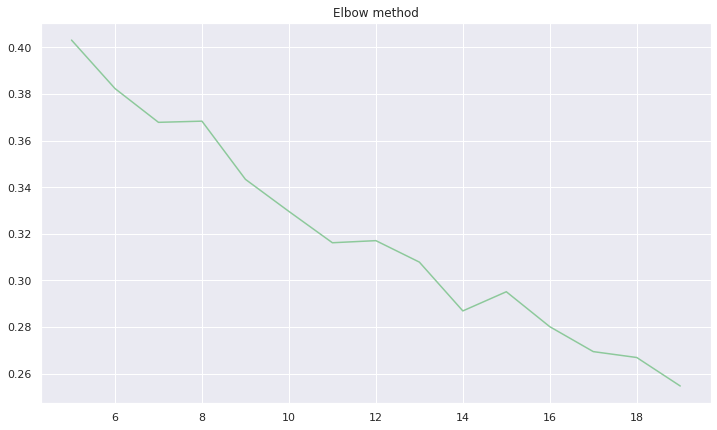

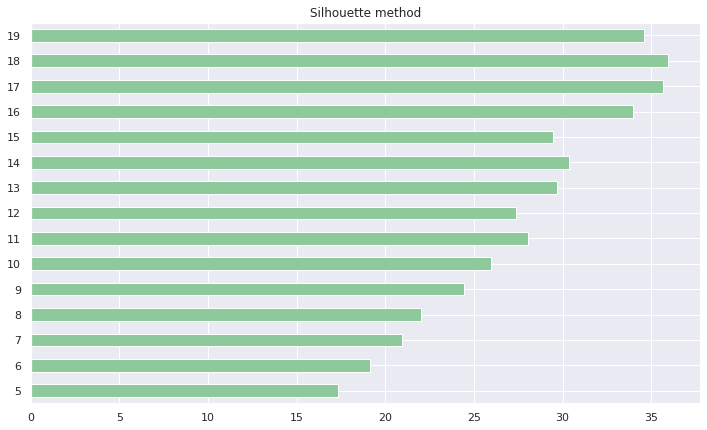

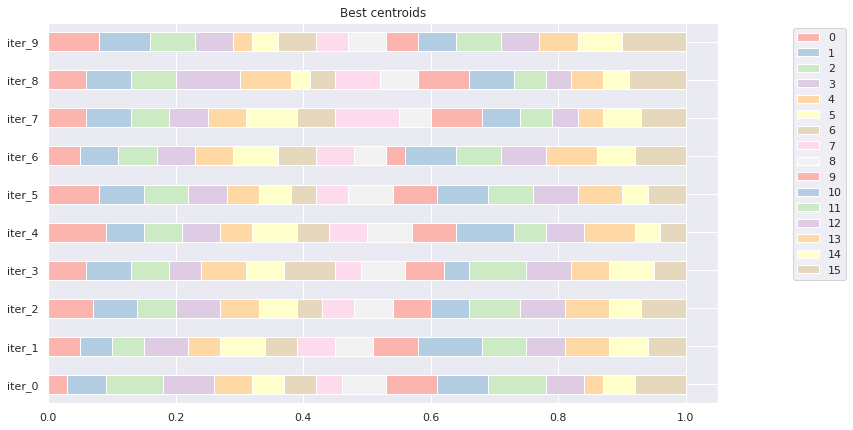

In [8]:
optimal_centroids, optimal_k = optimize(m,10)

In [9]:
clusters, centroids, n_clusters, WSS = kmeans(optimal_k,m,optimal_centroids)
clusters

{0: [1, 40, 72, 89, 91],
 1: [0, 19, 42, 65, 81, 96],
 2: [7, 46, 70, 73, 80, 93],
 3: [17, 23, 31, 50, 59, 92],
 4: [15, 18, 27, 47, 53, 54],
 5: [2, 16, 35, 39, 71, 75, 86],
 6: [28, 29, 34, 43, 61, 85],
 7: [4, 25, 30, 58, 60, 64],
 8: [56, 63, 67, 88, 99],
 9: [6, 22, 97],
 10: [3, 37, 41, 48, 51, 62, 74, 78],
 11: [10, 20, 24, 57, 79, 95, 98],
 12: [5, 12, 45, 49, 66, 87, 94],
 13: [8, 9, 36, 44, 55, 69, 77, 82],
 14: [14, 26, 32, 33, 52, 76],
 15: [11, 13, 21, 38, 68, 83, 84, 90]}

## Plotting

Colors

In [10]:
a=sns.color_palette('Set1')
b=sns.color_palette('Set2')
c=sns.color_palette('Set3')
#palette1 = ['#264653','#FFADAD','#6a994e','#CAFFBF','#FFC6FF','#E63946','#E9C46A','#9a031e','#F1FAEE','#a5ffd6','#B3FBDF','#1D3557','#343a40','#FFC2A9','#BDB2FF','#FFD6A5','#6d597a','#9BF6FF','#FDFFB6']
palette2 = a+b+c
palette = palette2[:len(clusters.keys())]

https://stackoverflow.com/questions/44575681/how-do-i-encircle-different-data-sets-in-scatter-plot

In [11]:
def encircle(x,y, ax=None, **kw):
    ''' This function encircle points beloning to the same cluster to make visualization easier'''
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    mean = np.mean(p, axis=0)
    d = p-mean
    r = np.max(np.sqrt(d[:,0]**2+d[:,1]**2 ))
    circ = plt.Circle(mean, radius=1.05*r,**kw)
    ax.add_patch(circ)

### 1D

Here we represent all points on a straight line and we plot each point according to their distance to a reference point0.

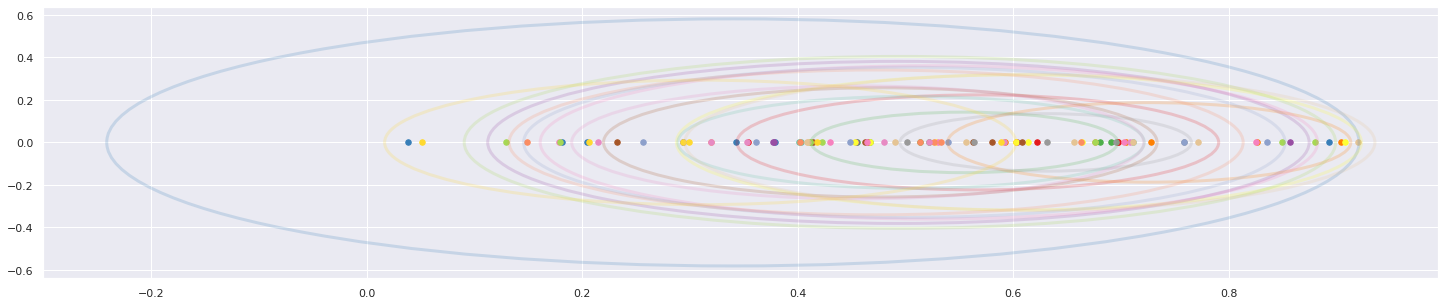

In [12]:
''' Needs to be modified by taking into account two reference points'''
plt.figure(figsize=(25,5))
palette = palette2[:len(clusters.keys())]
positions={}
for k, c in zip(clusters.keys(), palette):
    cluster = []
    for point in clusters[k]:
        cluster.append(m[0][point])
    positions[k] = cluster
    plt.scatter(cluster, [0]*len(cluster), color=c, s =30)
    encircle(cluster, [0]*len(cluster), ec=c, fc="none",linewidth=3,alpha=0.2)

### 2D
#### PCA in 2 dimentions 
Here we want to explain the distance among all points by taking the first two compnents from PCA. In order to assign colors we build a dictionary which assignes the 2D coordinates of each point to each cluster.
https://stackoverflow.com/questions/39988107/how-to-get-point-coordinates-from-distance-matrix

In [13]:
'''PCA coordinates'''
df = pd.DataFrame(data=m)
pca_2d = PCA(n_components=2)
X2d = pca_2d.fit_transform(df)

In [14]:
''' Clusters points '''
positions={}
for k in clusters.keys():
    cluster = []
    for point in clusters[k]:
        cluster.append([X2d[point][0],X2d[point][1]])
    positions[k] = np.array(cluster)

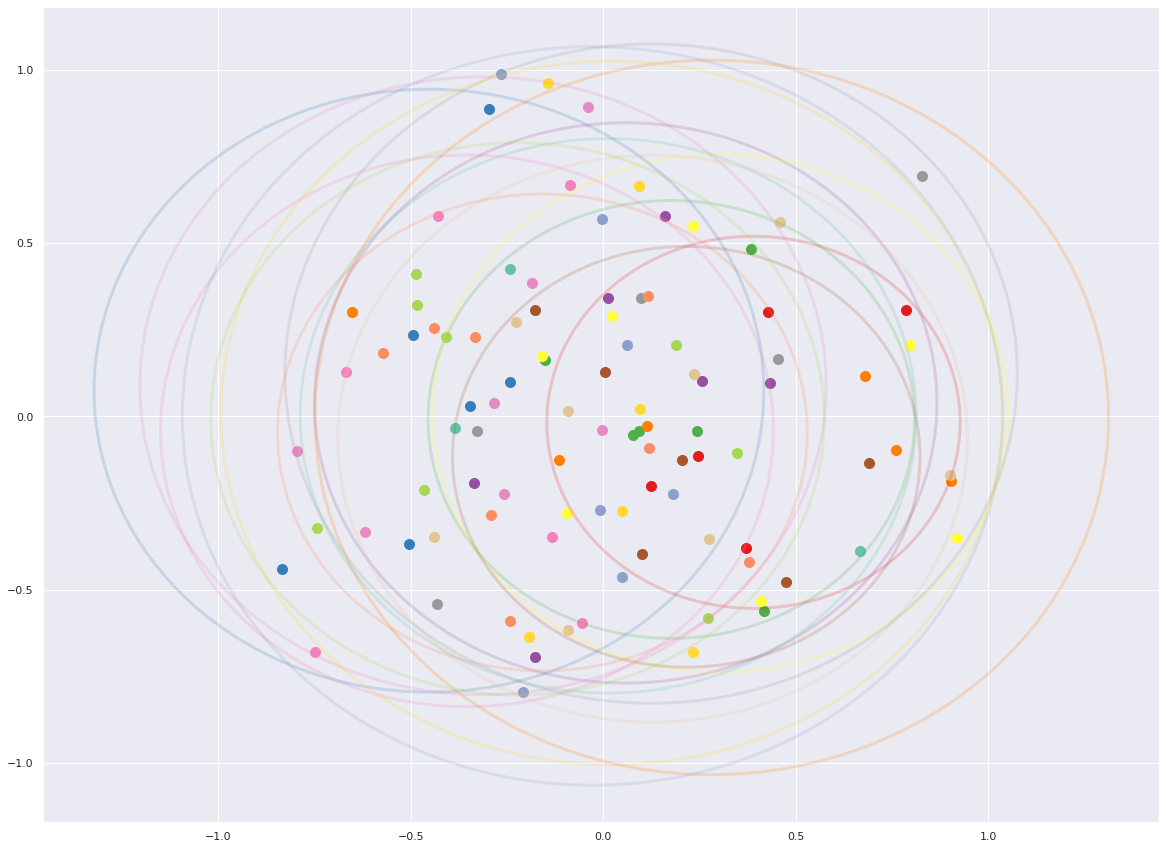

In [16]:
''' Plot '''
plt.figure(figsize=(20,15))
for k, c in zip(positions.keys(), palette):
    plt.scatter(positions[k][:,0], positions[k][:,1], color=c, s =100)
    encircle(positions[k][:,0], positions[k][:,1], ec=c, fc="none",linewidth=3,alpha=0.2)

#### Heatmap

Here we want to represent points with a different 2D visualization. Each cell indicates the distance between two points. The left colored bar indicates the cluster that point belongs to. The dendograms indicate how all points cluster together.

In [17]:
''' We create a dictionary where keys are points (products) 
and values are the number of the cluster they are associated to.
We will produce a series where points are ordered to produce an annotation.'''
points = {}                                                   
for k in clusters.keys():                                    
    points.update(dict(zip(clusters[k],[k]*len(clusters[k])))) 
clusters_vector = pd.Series(list(collections.OrderedDict(sorted(points.items())).values()))

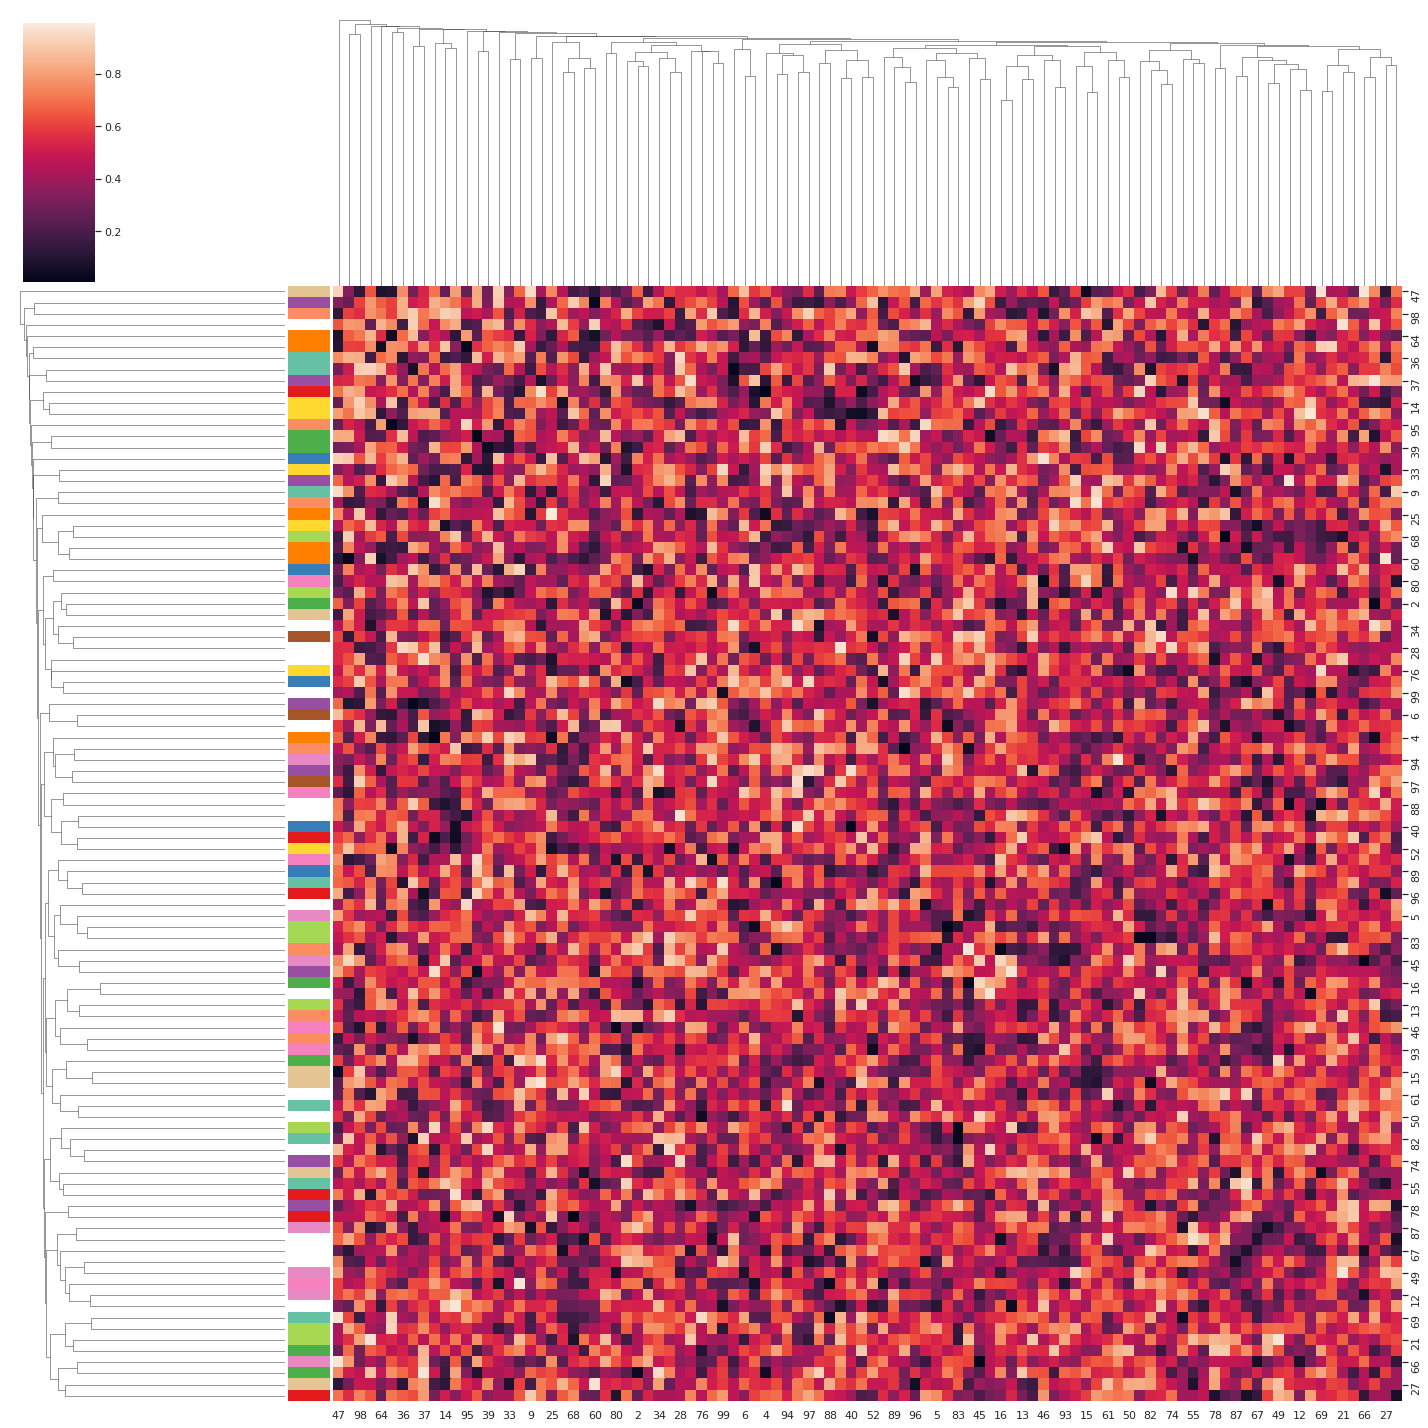

In [25]:
''' Heatmap with annotation for clusterization '''
matrix = pd.DataFrame(m)
products_ids = range(len(m))
color_annotation = dict(zip(clusters_vector, palette))
row_colors = clusters_vector.map(color_annotation)
g = sns.clustermap(matrix, row_colors=row_colors, figsize=(20,20));

#### Assigning 2d coordinates

Work in progress

https://stackoverflow.com/questions/10963054/finding-the-coordinates-of-points-from-distance-matrix

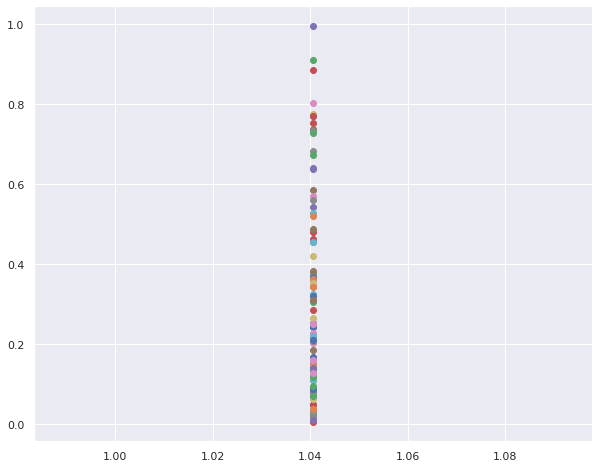

In [41]:
''' Incomplete '''
# arbitrarily assign one point A as (0,0).
A = (0,0)
# assign another point on y axis with fixed distance from A
B = (0,m[0][1])
# initiate coordinates matrix
coord_2d = [A, B]
#assign a 3rd point by using its distance from A an B, we select the positive solution
d_AB = m[0][1]
d_AC = m[0][point]
d_BC = m[1][point]
xC = (d_AB**2+d_AC**2+d_BC**2)/(2*d_AB)
yC = math.sqrt(abs((d_AB+d_AC+d_BC)*(d_AB+d_AC-d_BC)*(d_AB-d_AC-d_BC)*(-d_AB+d_AC+d_BC)))/(2*d_AB)
C = (xC,yC)

plt.figure(figsize=(10,8))

for point in range(3,len(m)):
    d_AB = m[0][1]
    d_AP = m[0][point]
    d_BP = m[1][point]
    xP = (d_AB**2+d_AC**2+d_BC**2)/(2*d_AB)
    yP1 = math.sqrt(abs((d_AB+d_AP+d_BP)*(d_AB+d_AP-d_BP)*(d_AB-d_AP-d_BP)*(-d_AB+d_AP+d_BP)))/(2*d_AB)
    yP2 = - math.sqrt(abs((d_AB+d_AP+d_BP)*(d_AB+d_AP-d_BP)*(d_AB-d_AP-d_BP)*(-d_AB+d_AP+d_BP)))/(2*d_AB)
    P1 = (xP,yP1)
    P2 = (xP,yP2) 
    # euclidean distance from fixed point to decide direction
    dist1 = math.sqrt((xP-xC)**2 + (yP1-yC)**2)
    dist2 = math.sqrt((xP-xC)**2 + (yP2-yC)**2)
    dist = m[2][3]
    if dist1 == dist:
        coord_2d.append(P1)
    elif dist2 == dist:
        coord_2d.append(P2)
    plt.scatter(xP,yP1);

### 3D 
#### PCA
Here we repeat the same approach as before but now using three components to explain our data. The points are coloured by cluster. \
https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

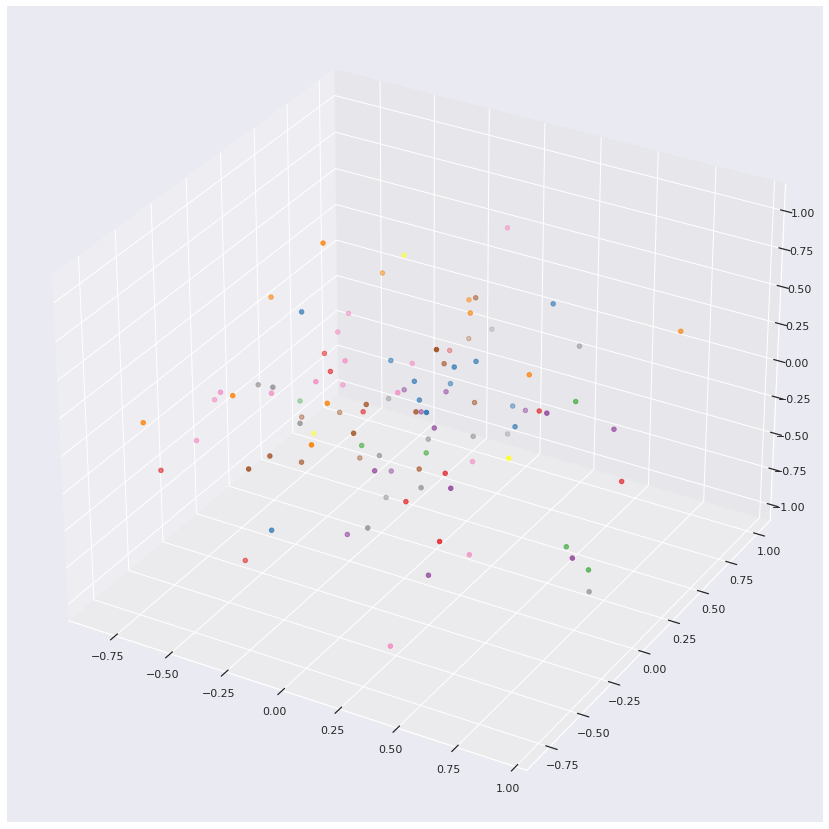

In [26]:
'''3D PCA plot'''
viridisBig = cm.get_cmap('Set1', len(clusters.keys()))
pca_3d = PCA(n_components=3)
X3d = pca_3d.fit_transform(df)
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection="3d")
ax.scatter3D(X3d[:,0],X3d[:,1],X3d[:,2], c=clusters_vector, cmap='Set1')
plt.show()

### Comapring to built in k-means ++
Here we compare the built in K-means function to our implementation considering the number of clusters and the inertia of these two clusterizazion. 

In [27]:
def compare(m):
    
    print('### Built-in K-means ++ ###')
    kmeans1 = KMeans().fit(m)
    print('Number of clusters is ',len(kmeans1.labels_))
    # print('Centroids are ',kmeans1.cluster_centers_)
    print('The WSS score is ',kmeans1.inertia_)
    plt.figure(figsize=(12,7))
    elbow = {}
    for k in range(5, 20):
        model = KMeans(k)
        model.fit(m)
        model.predict(m)    
        elbow[k] = model.inertia_
    plt.plot(list(elbow.keys()),list(elbow.values()),color='#8DC99B')
    plt.title('Elbow method - K-means ++')
    plt.show()
    
    
    print('### Implemented K-means with random inizialization ###')
    optimal_centroids, optimal_k = optimize(m,10)
    clusters, centroids, n_clusters, WSS = kmeans(optimal_k,m,optimal_centroids)
    print('Number of clusters is ',optimal_k)
    print('Centroids are ', optimal_centroids)
    print('The WSS score is ',WSS)

### Built-in K-means ++ ###
Number of clusters is  100
The WSS score is  377.4250642968317


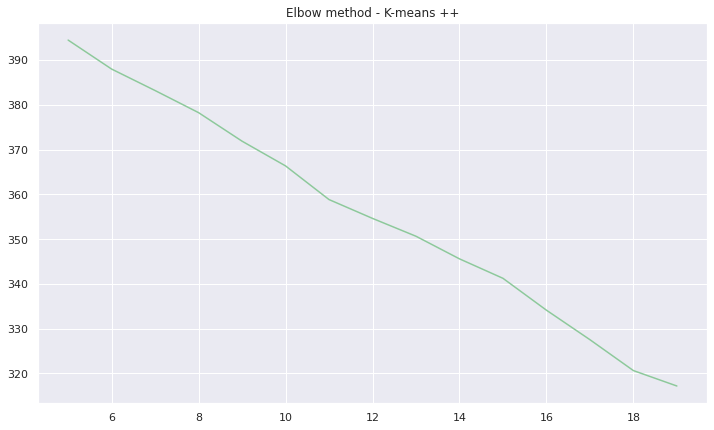

### Implemented K-means with random inizialization ###
Elbow method: Optimal number of clusters is 15
Silhouette method: Optimal number of clusters is 18
The best iteration is 6  whith centroids: [24, 92, 94, 44, 52, 48, 5, 63, 33, 18, 38, 1, 87, 93, 79, 77]


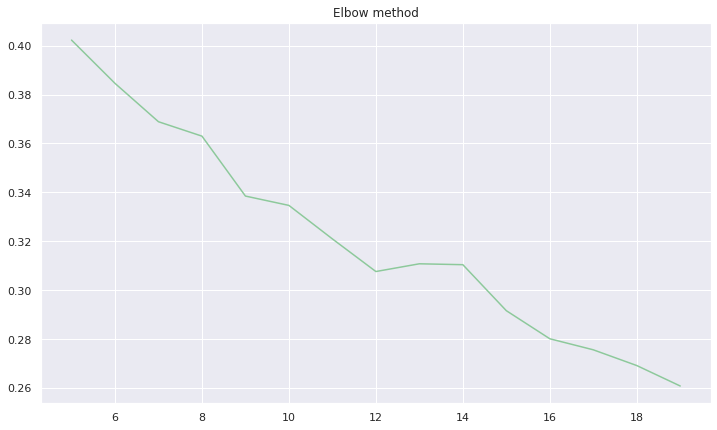

Number of clusters is  16
Centroids are  [24, 92, 94, 44, 52, 48, 5, 63, 33, 18, 38, 1, 87, 93, 79, 77]
The WSS score is  0.2728997909270258


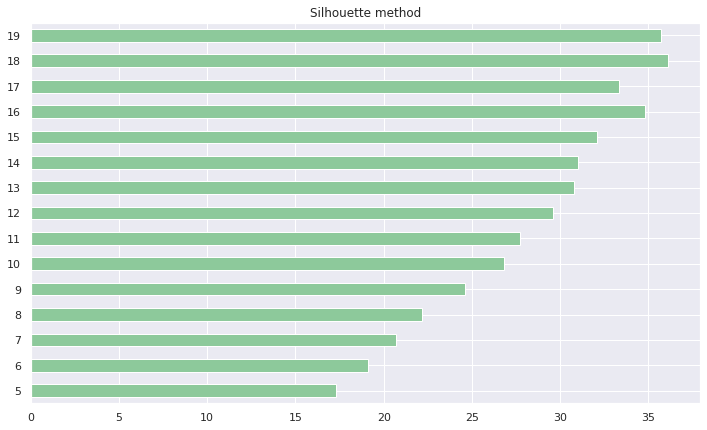

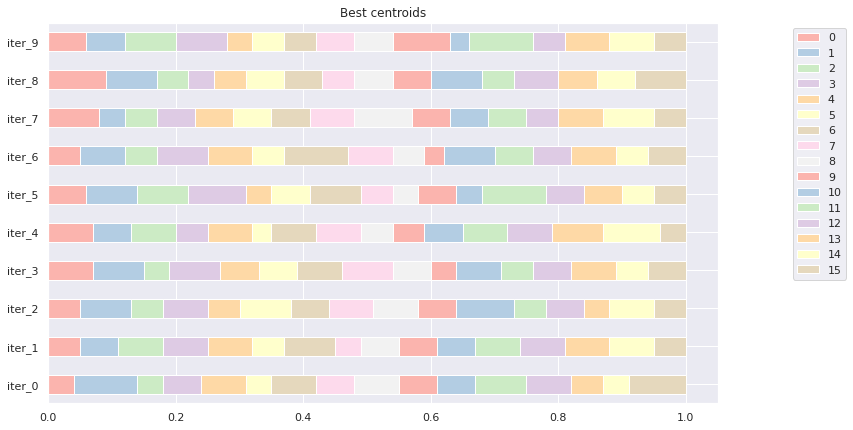

In [28]:
compare(m)

### Visualizing results

In [ ]:
def word_cloud(cluster):
    return plots

In [ ]:
def score_distribution(cluster):
    return score

In [ ]:
def analyze(clusters):
    for cluster in clusters:
        plots = word_cloud(cluster)
        numberOfProds = set(df.products)
        scoreDistro = score_distribution(cluster)
        uniqueUsers = set(df.users)
    return plots, numberOfProds, scoreDistro, uniqueUsers

## 3. ARLGORITHM
Prove that we can sort A in time O(n + r).
https://it.wikipedia.org/wiki/Counting_sort

In [ ]:
s = min{ A[1], ..., A[n] } 
b = max { A[1], ..., A[n] }.
r = b - s